# The fingerprint of anthropogenic warming on wet bulb temp in CMIP6 models
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [2]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from eofs.xarray import Eof

Data location

In [3]:
loc_cmip6 = "../Data/Tw/CMIP6/"
loc_obs = "../Data/Tw/ERA5/"
loc_out = "../Data/Fingerprint/"

models

In [4]:
models = ["access-cm2","access-esm1-5","bcc-csm2-mr",\
            "canesm5","fgoals-g3","mri-esm2-0"]
nmodels = len(models)

Years

In [5]:
y1 = 1980
y2 = 2019
y1_fp = 1980
y2_fp = 2017

Functions

In [6]:
def find_linear_trend(data):
    # time x lat x lon data
    # first a wrapper function to just
    # get the single linear trend coefficient
    # from np.polyfit
    def linear_trend_coef(x, y):
        pf = np.polyfit(x, y, 1)
        return xr.DataArray(pf[0])
    # create dummy array of time values (from 1 to length of the data)
    # for each lat/lon point
    timevals = xr.DataArray(np.arange(1,len(data.time)+1,1),
                        coords=[data.time],dims=["time"])
    timevals = timevals.expand_dims(lat=data.lat,lon=data.lon)
    # apply linear_trend_coef
    # to "timevals" and "data"
    # at each grid point
    linear_trend = xr.apply_ufunc(linear_trend_coef,timevals,data,
                            vectorize=True,input_core_dims=[["time"],["time"]])
    return(linear_trend)

def find_linear_trend_pvalue(data):
    # time x lat x lon data
    # first a wrapper function to just
    # get the p-value on the linear trend
    # from stats.linregress
    def linear_pval(x, y):
        slope, intercept, rvalue, pvalue, se = stats.linregress(x,y)
        return(pvalue)
    # create dummy array of time values (from 1 to length of the data)
    # for each lat/lon point
    timevals = xr.DataArray(np.arange(1,len(data.time)+1,1),
                        coords=[data.time],dims=["time"])
    timevals = timevals.expand_dims(lat=data.lat,lon=data.lon)
    # apply linear_pval
    # to "timevals" and "data"
    # at each grid point
    linear_p = xr.apply_ufunc(linear_pval,timevals,data,
                            vectorize=True,input_core_dims=[["time"],["time"]])
    return(linear_p)

#### Analysis

Read in CMIP6 Tw

In [7]:
for m in models:
    print(m)
    tw_in_1 = xr.open_dataset(loc_cmip6+m+"_tw_davies-jones_summer_"+str(y1)+"-"+str(y2)+".nc").tw_max
    tw_in = tw_in_1.loc[:,-60:60,:]
    time = tw_in.time
    lat = tw_in.lat
    lon = tw_in.lon
    if models.index(m)==0:
        tw_max_all = xr.DataArray(np.full((len(models),len(time),len(lat),len(lon)),np.nan),
                                 coords=[models,time,lat,lon],
                                 dims=["model","time","lat","lon"])
    tw_max_all.loc[m,:,:,:] = tw_in.values
    
#ds = xr.open_mfdataset(loc_cmip6+"*_tw_davies-jones_summer_"+str(y1)+"-"+str(y2)+".nc",
#                      concat_dim="model",combine="nested")
#ds.coords["model"] = models

access-cm2
access-esm1-5
bcc-csm2-mr
canesm5
fgoals-g3
mri-esm2-0


In [8]:
tw_max = tw_max_all.mean(dim="model")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trends in tw max

In [12]:
tw_max_trends = find_linear_trend(tw_max)

What about global mean?

In [14]:
tw_max_global = tw_max.mean(dim=["lat","lon"])
tw_max_global.coords["time"] = tw_max_global.time.dt.year.values

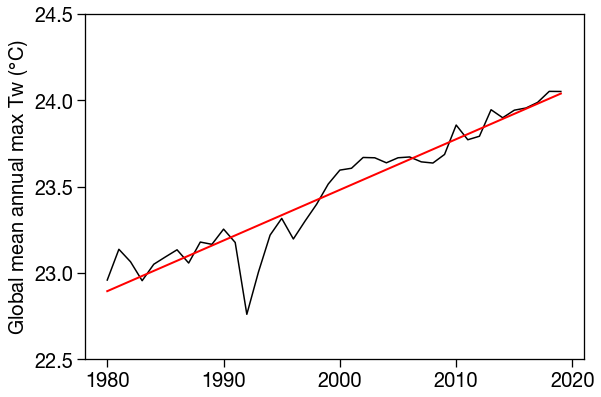

In [15]:
fig = plt.figure(figsize=(9,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.15,right=0.92,top=0.9,bottom=0.1,wspace=0.2,hspace=0.28)

ax = plt.subplot(gs1[0,0])

plt.plot(tw_max_global.time,tw_max_global,linewidth=1.5,
         color="black")
lm = np.polyfit(tw_max_global.time.values,tw_max_global.values,1)
yhat = np.polyval(lm,tw_max_global.time.values)
plt.plot(tw_max_global.time.values,yhat,color="red",linewidth=2)

#plt.title("CMIP6 land wet bulb temperature",pad=10)
plt.ylim([22.5,24.5])
plt.yticks([22.5,23,23.5,24,24.5])
plt.ylabel("Global mean annual max Tw ($\degree$C)")

#plt.text(2011,10.6,"P < 0.001",color="red")

plt.show()

Now we'll create a set of anthropogenic signals "fingerprints". The trend map and EOFs, in particular.

In [19]:
fp1 = find_linear_trend(tw_max.loc[str(y1_fp)+"-01-01":str(y2_fp)+"-12-31",:,:])

Calc EOF

In [20]:
nmodes = 4

In [21]:
eof_solver = Eof(tw_max.loc[str(y1_fp)+"-01-01":str(y2_fp)+"-12-31",:,:])
eofs = eof_solver.eofs(neofs=nmodes)
pcs = eof_solver.pcs(pcscaling=1,npcs=nmodes)
vf = eof_solver.varianceFraction(neigs=nmodes)

In [22]:
fp2 = eofs.loc[0,:,:]

Write out fingerprints

In [19]:
lat = fp1.lat
lon = fp1.lon

In [23]:
fp_out = xr.Dataset({"fingerprint1":(["lat","lon"],fp1.values),
                     "fingerprint2":(["lat","lon"],fp2.values)},
                    coords={"lat":("lat",lat),
                            "lon":("lon",lon)})

fp_out.attrs["creation_date"] = str(datetime.datetime.now())
fp_out.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
fp_out.attrs["variable_description"] = "fingerprint1: linear trend map; fingerprint2: leading EOF of ensemble mean"
fp_out.attrs["created_from"] = os.getcwd()+"/CMIP6_Tw_Fingerprint"

fname_out = loc_out+"CMIP6_tw_fingerprints_"+str(y1_fp)+"-"+str(y2_fp)+".nc"
fp_out.to_netcdf(fname_out,mode="w")
print(fname_out,flush=True)

/dartfs-hpc/rc/lab/C/CMIG/ccallahan/Other/Class/TMD/Fingerprint/CMIP6_tw_fingerprints_1980-2017.nc
